In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

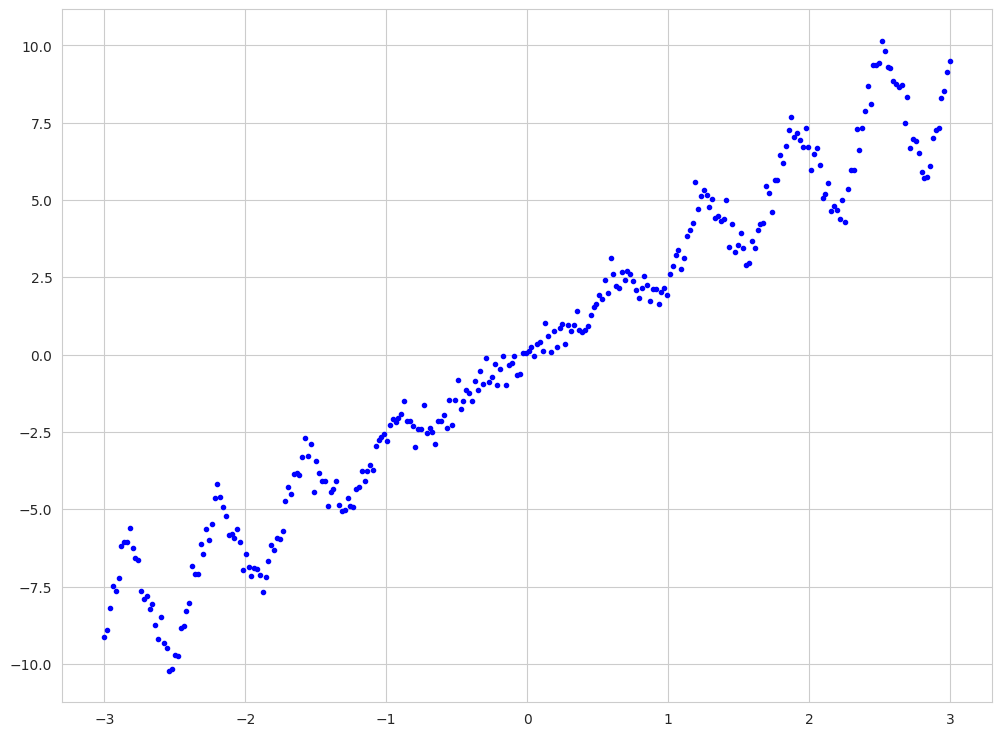

In [4]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [5]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

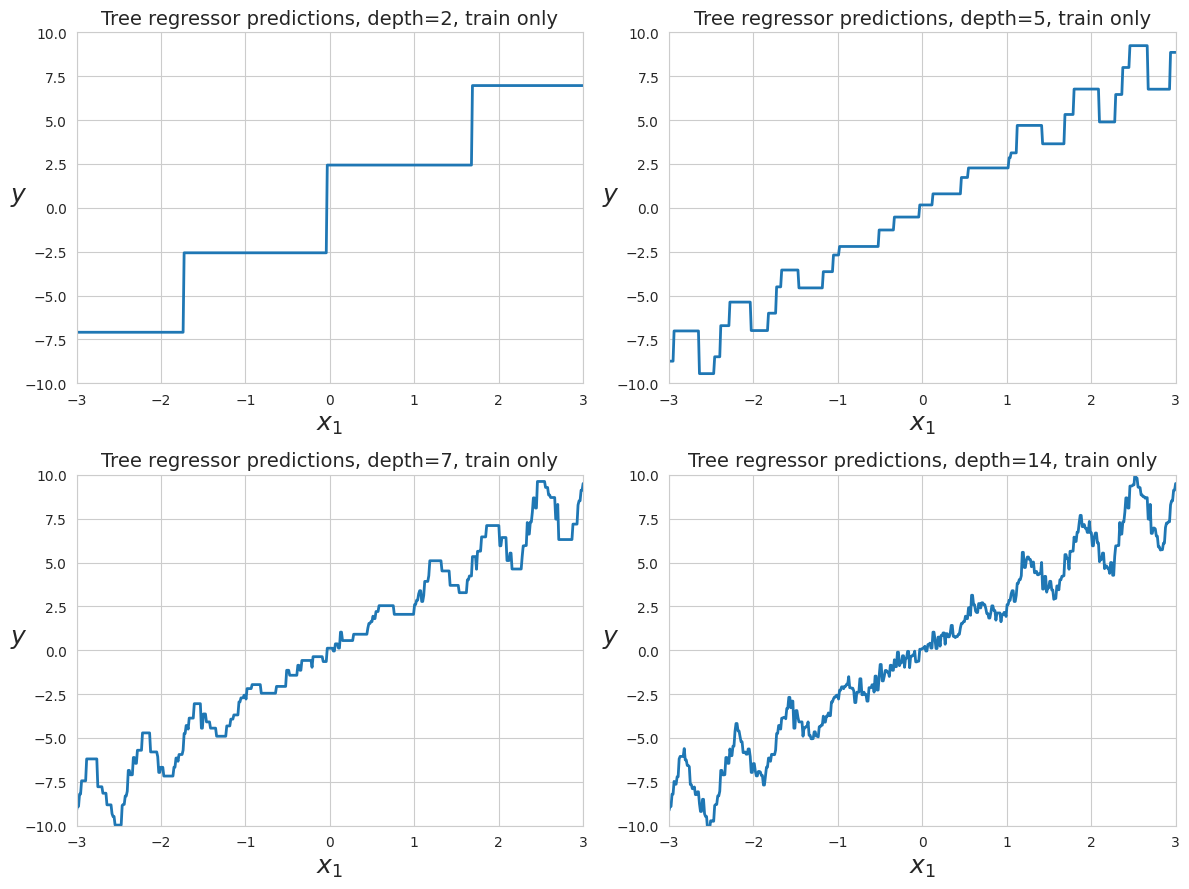

In [6]:
for i, n in enumerate([2, 5, 7, 14]):
    plt.subplot(2, 2, i + 1)
    tree_reg = DecisionTreeRegressor(max_depth=n)
    tree_reg.fit(X,y)
    plt.title(f"Tree regressor predictions, depth={n}, train only", fontsize=14)
    plot_regression_predictions(tree_reg, X, y)

plt.tight_layout()
plt.show()

> Примерно начиная с глубины дерева = 7, модель снижает bias и имеет еще не очень высокий variance. Теперь оценим variance модели с глубиной 14, обучив ее на разных выборках из исходных данных.

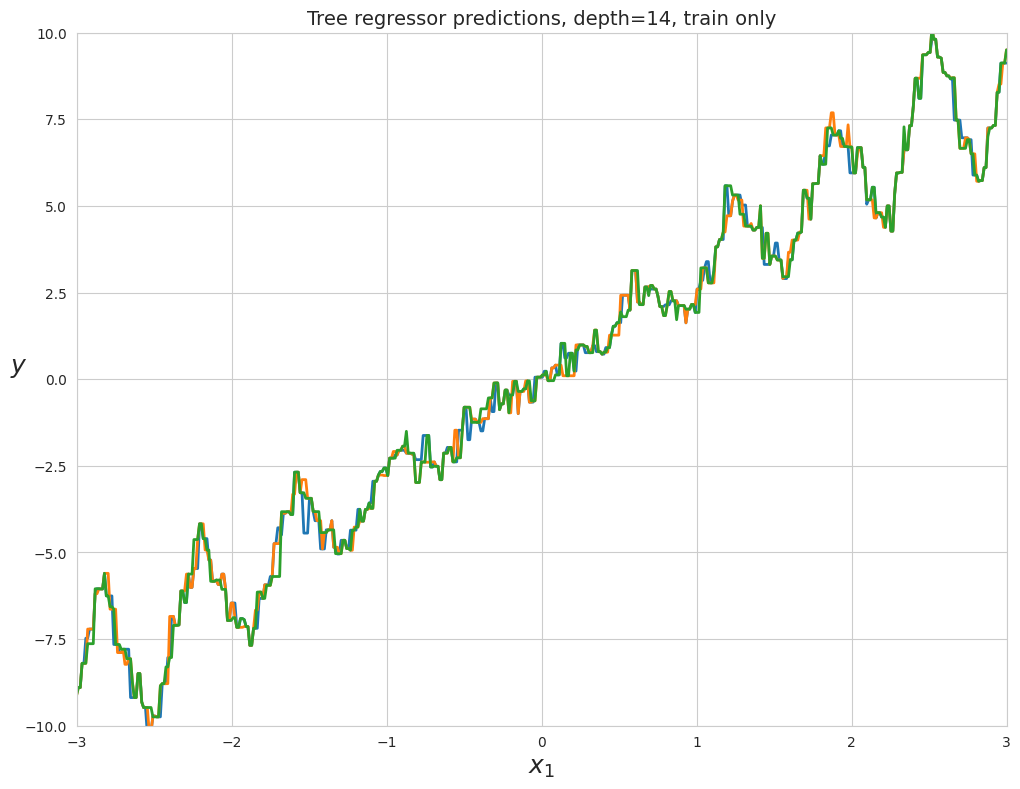

In [7]:
for i in range(1, 4):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
    tree_reg = DecisionTreeRegressor(max_depth=14, random_state=0)
    tree_reg.fit(X_train, y_train)
    plot_regression_predictions(tree_reg, X_train, y_train)
plt.title(f"Tree regressor predictions, depth=14, train only", fontsize=14)
plt.show()

> Видим, что модель переобучена, и небольшое изменение тренировочных данных влияет на предсказания (то есть она имеет высокий **variance**).

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балл**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

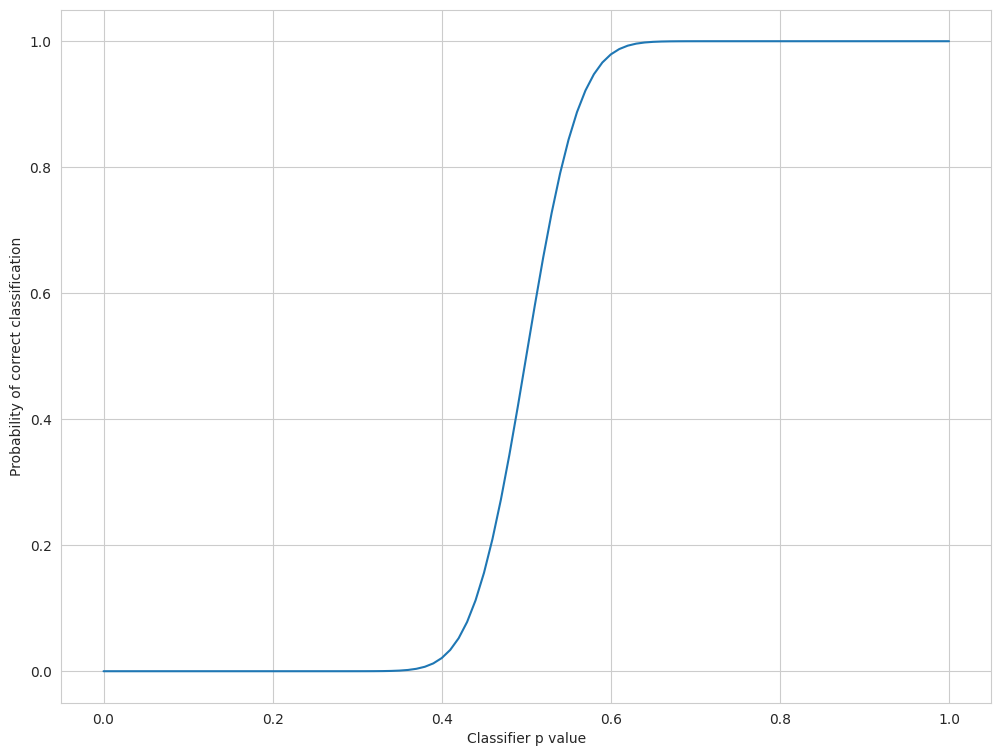

In [8]:
def probability_of_correct_classification(p):
    mu = sum(math.comb(101, i) * (p ** i) * ((1 - p) ** (101 - i)) for i in range(51, 102))
    return mu

p_values = np.linspace(0, 1, 101)
probabilities = [probability_of_correct_classification(p) for p in p_values]

plt.plot(p_values, probabilities)
plt.xlabel('Classifier p value')
plt.ylabel('Probability of correct classification')
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

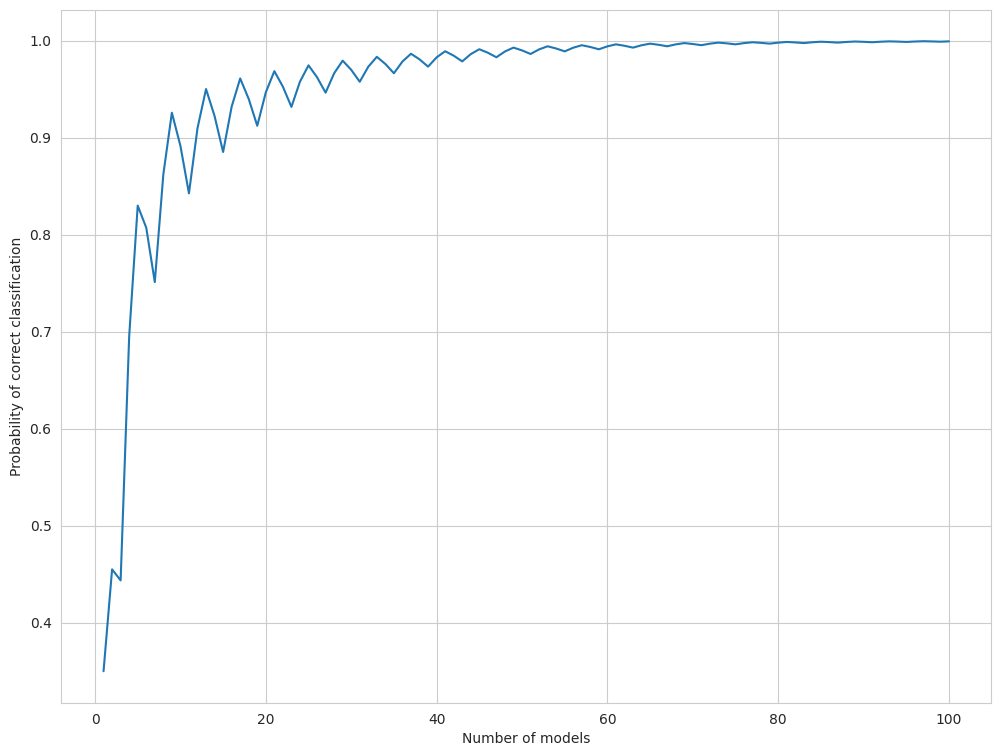

In [9]:
def probability_of_correct_classification(models_number, p = 0.65):
    mu = sum(math.comb(models_number, i) * (p ** i) * ((1 - p) ** (models_number - i)) for i in range(round(models_number/2), models_number))
    return mu

models_number_values = np.arange(1, 101)
probabilities = [probability_of_correct_classification(models_number) for models_number in models_number_values]

plt.plot(models_number_values, probabilities)
plt.xlabel('Number of models')
plt.ylabel('Probability of correct classification')
plt.show()

Опишите ваши наблюдения:

* При фиксированном числе моделей в ансамбле (101) максимальная точность предсказаний достигается уже с примерно с p = 0.65 для отдельно взятого классификатора.
* При этом, вероятность правильно классифицировать объект при p = 0.65 зависит от количества моделей в ансамбле: она ожидаемо растет с увеличением числа моделей, а начиная от числа моделей 80 и более - достигает максимума.

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [10]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y): 
              
        self.classes_ = sorted(np.unique(y))
        for i in range(self.n_estimators):
            np.random.seed(self.random_state+i)

            feat_ids = np.random.choice(X.shape[1], size=self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_ids.tolist())
            
            boot_ids = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
            x_boot = X[boot_ids]
            y_boot = y[boot_ids]

            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                max_features=self.max_features,
                random_state=self.random_state
            )
            tree.fit(x_boot[:, feat_ids], y_boot)
            self.trees.append(tree)

        return self

    def predict_proba(self, X):
        y_pred_proba = np.zeros(shape=(X.shape[0], len(self.classes_)))
        for i in range(self.n_estimators):
            feat_ids = self.feat_ids_by_tree[i]
            y_pred_proba += self.trees[i].predict_proba(X[:, feat_ids])
        
        return y_pred_proba / self.n_estimators
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [11]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

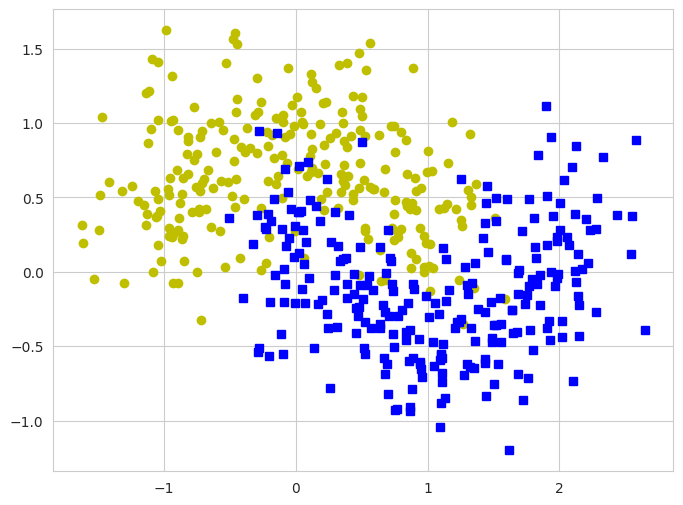

In [12]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [13]:
# Попробуем подобрать гиперпараметры с помощью GridSearchCV
param_grid = {'max_depth': range (2,20,2),
              'n_estimators': range (2,100,10),
              'max_features': [1,2]
              }

random_tree_clf = RandomForestClassifierCustom()

grid_search = GridSearchCV(estimator=random_tree_clf, param_grid=param_grid, cv=5, verbose=True, scoring='accuracy')
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Fitting 5 folds for each of 180 candidates, totalling 900 fits


RandomForestClassifierCustom(max_depth=6, max_features=2, n_estimators=72)

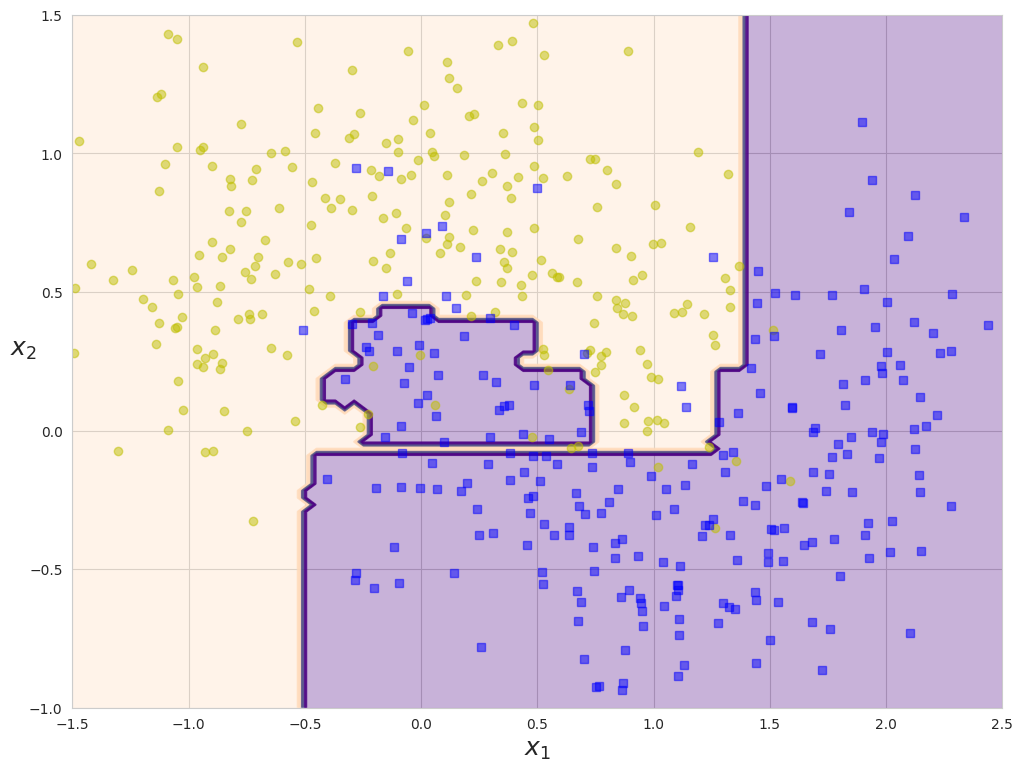

In [14]:
random_tree_clf = RandomForestClassifierCustom(max_depth=6, max_features=2, n_estimators=72)
random_tree_clf.fit(X_train, y_train)
plot_decision_boundary(random_tree_clf, X, y)

Визуально модель выглядит довольно сбалансированной с точки зрения bias-variance trade-off (возможно bias еще можно скорректировать).

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выяcнили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [15]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [16]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
# Количество всех фичей - 30 
X.shape

(569, 30)

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [18]:
corrs = {}

for max_features in [2, 5, 10, 15, 30]:
    ensemble = RandomForestClassifier(max_features=max_features)
    ensemble.fit(X_train, y_train)
    corrs[f"{max_features}"] = base_model_pair_correlation(ensemble, X_test)

corrs_df = pd.DataFrame.from_dict(corrs)

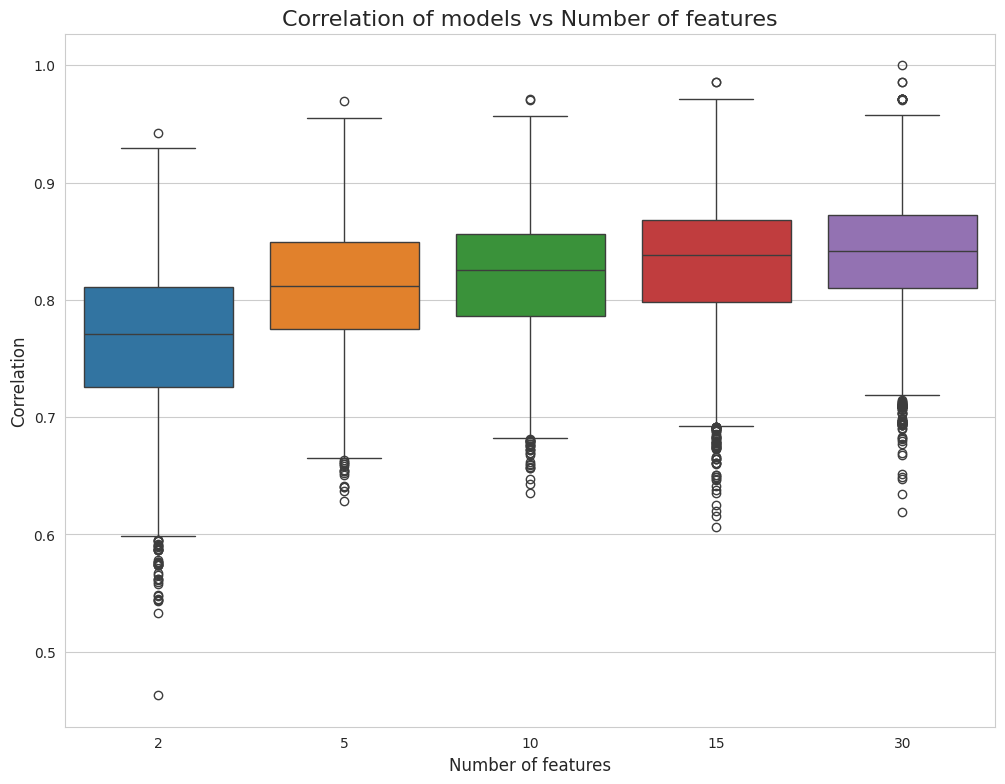

In [19]:
# Построим бокс-плот с результатами
sns.boxplot(data=corrs_df)
plt.ylabel("Correlation", size=12)
plt.xlabel("Number of features", size=12)
plt.title("Correlation of models vs Number of features", size=16)
plt.show()

Опишите ваши наблюдения:

* Чем меньше фичей выбирается для каждой базовой модели в ансамбле, тем менее скоррелированными получаются их предсказания (хотя разница не очень большая).
* Следовательно, при использовании подхода bagging лучше не использовать высокие значения параметра max_features.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [20]:
heart_dataset = pd.read_csv("../data/heart.csv")

In [21]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [22]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [23]:
voting_hard = VotingClassifier(base_models, voting='hard', n_jobs=-1)
voting_soft = VotingClassifier(base_models, voting='soft', n_jobs=-1)

## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.8281746031746032
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

**Результаты:**
- DecisionTreeClassifier: 0.797997226792219
- RandomForestClassifier: 0.8328751280279528
- CatBoostClassifier: 0.8342715174922052
- ExtraTreesClassifier: 0.8281746031746032
- KNeighborsClassifier: 0.6493313763861709
- SVC-lin: 0.8403098469098905
- SVC-rbf: 0.6973119072190279
- XGBClassifier: 0.8134522115571786
- LGBMClassifier: 0.817010631644778
- XGBRFClassifier: 0.8499478840942256
- LGBMClassifier-rf: 0.8132478632478634
- **LogisticRegression: 0.8500073681108163**
- GaussianNB: 0.8140676625250128
- VotingClassifier (hard): 0.8494440278941667
- VotingClassifier (soft): 0.8455110375195781

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [24]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xj_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xj_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))

    return corrs

In [25]:
voting_hard.fit(X_train, y_train)
corrs = base_model_pair_correlation_for_voting_clf(voting_hard, X)

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [26]:
correlation_values = [corr[2] for corr in corrs]

base_model_names = voting_hard.estimators_
num_estimators = len(voting_hard.estimators_)
corr_matrix = np.zeros((num_estimators, num_estimators))

for i, (est1, est2, corr) in enumerate(corrs):
    idx1 = base_model_names.index(est1)
    idx2 = base_model_names.index(est2)
    corr_matrix[idx1][idx2] = corr
    corr_matrix[idx2][idx1] = corr

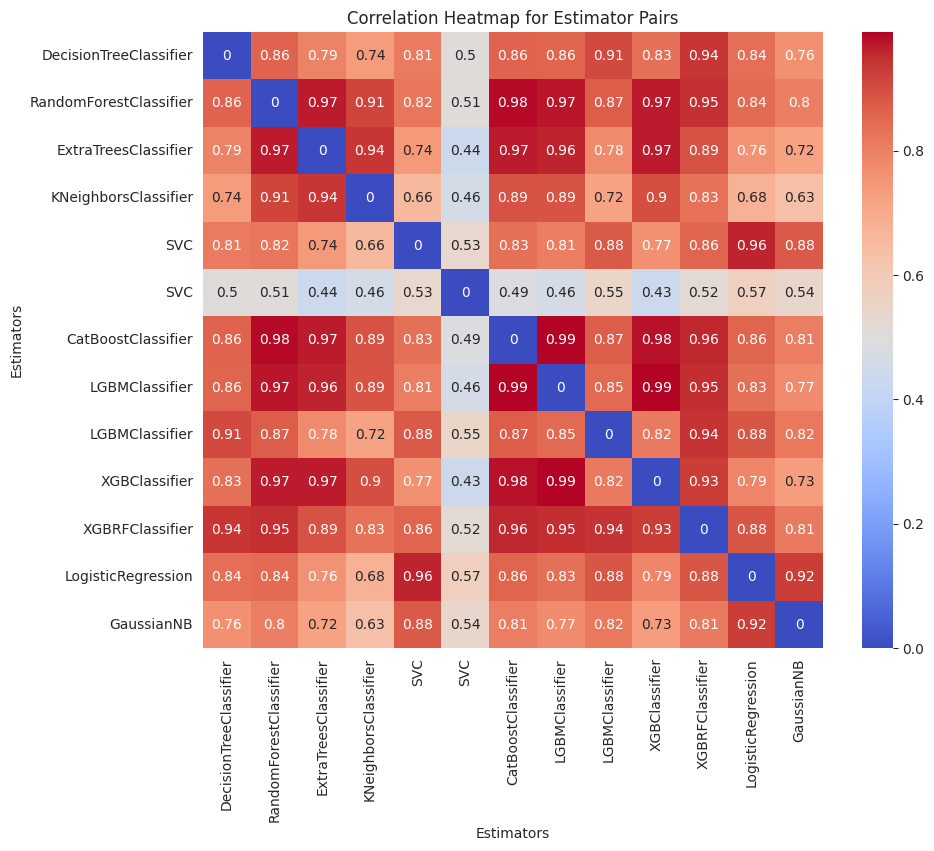

In [27]:
plt.figure(figsize=(10, 8))
base_model_names = [f"{est.__class__.__name__}" for est in voting_hard.estimators_]
sns.heatmap(corr_matrix, annot=True, xticklabels=base_model_names, yticklabels=base_model_names, cmap="coolwarm")
plt.title("Correlation Heatmap for Estimator Pairs")
plt.xlabel("Estimators")
plt.ylabel("Estimators")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [28]:
# Уберем базовые модели с высокой корреляцией между собой
voting_hard_optimized = voting_hard.set_params(RF='drop', ETC='drop', XGB='drop', XGB_RF='drop', CAT='drop', LGBM='drop')
voting_hard_optimized.fit(X_train, y_train)
cross_val_score(voting_hard_optimized, X_train, y_train, cv=3, scoring="f1").mean()

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[

0.8604756564807028

> Удалось немного повысить f1-score c **0.849** до **0.860**.

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [37]:
data = pd.read_csv("../data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


### EDA

In [30]:
number_rows, number_columns = data.shape
print(f"Rows: {number_rows}")
print(f"Columns: {number_columns}")

Rows: 3333
Columns: 21


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [32]:
cat_columns = ['Area Code', "Int'l Plan", 'VMail Plan', 'CustServ Calls', 'Churn?']
num_columns = ['Account Length', 
               'VMail Message',
                 'Day Mins',
                 'Day Calls', 
                 'Day Charge', 
                 'Eve Mins', 
                 'Eve Calls', 
                 'Eve Charge', 
                 'Night Mins', 
                 'Night Calls',
                 'Night Charge', 
                 'Intl Mins', 
                 'Intl Calls', 
                 'Intl Charge']

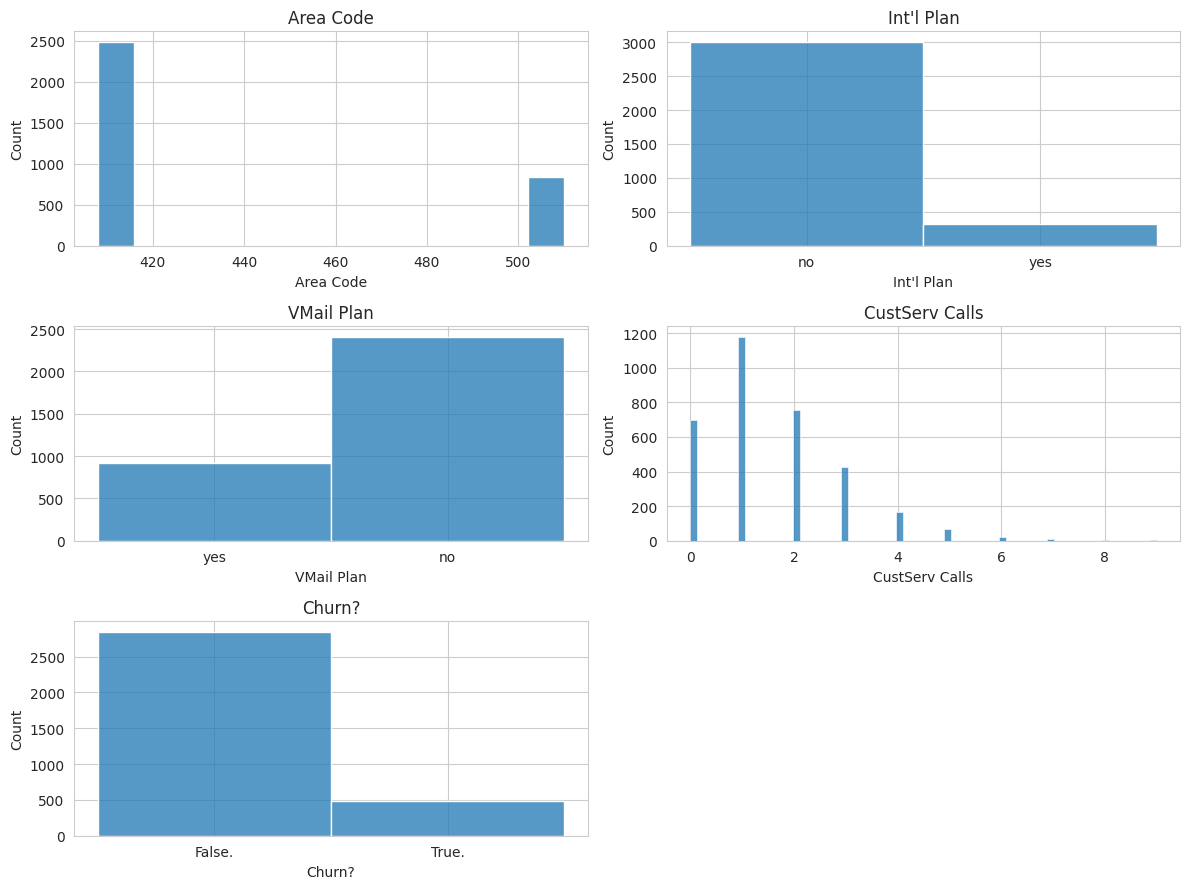

In [33]:
# Проверим сбалансированность категориальных переменных
for i, col in enumerate(cat_columns):
    plt.subplot(3, 2, i+1)
    sns.histplot(data[col])
    plt.title(col)
plt.tight_layout()

Категориальные переменные (в частности, таргетная переменная) довольно сильно не сбалансрованы.

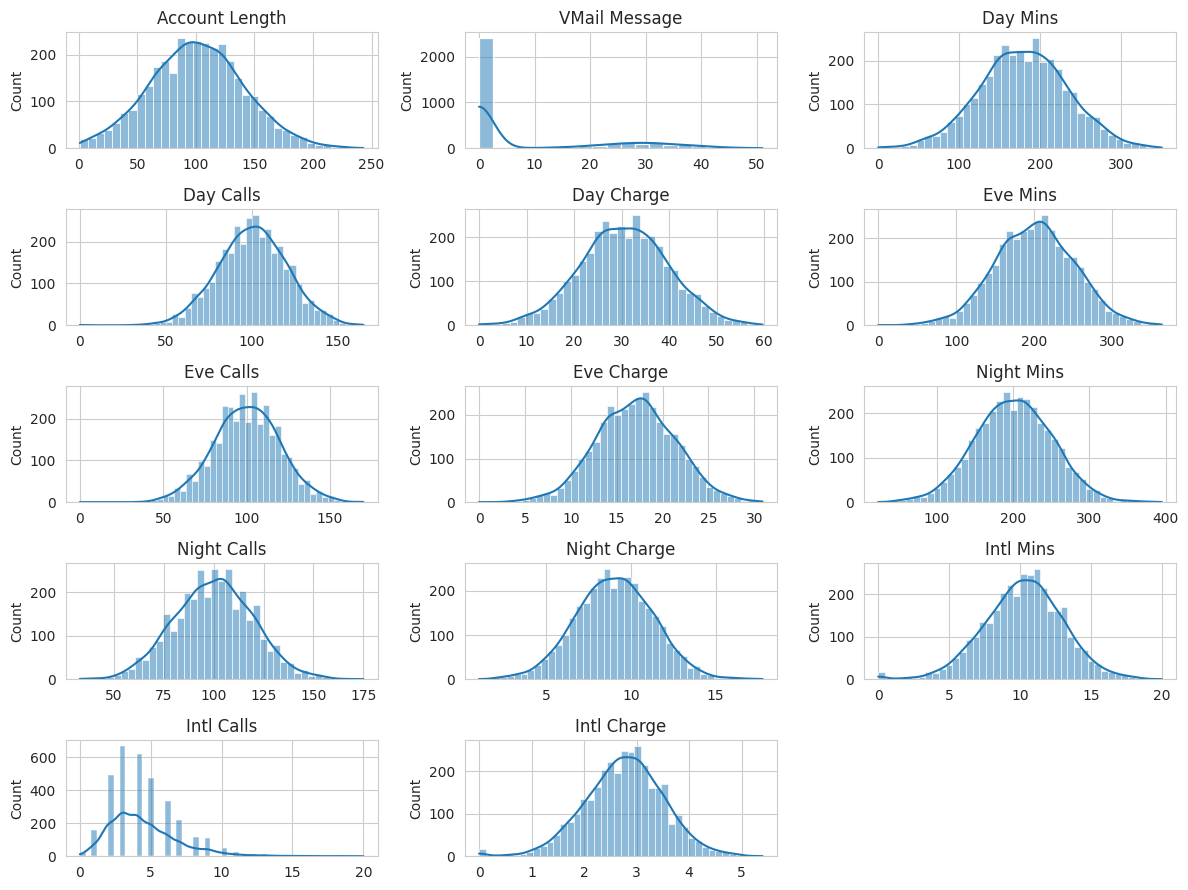

In [34]:
# Оценим распределение количественных переменных
for i, col in enumerate(num_columns):
    plt.subplot(5, 3, i + 1)
    ax = sns.histplot(data[col], kde = True)
    ax.set(xlabel=None)
    plt.title(col)
plt.tight_layout()
plt.show()

В целом, количественные признаки распределены нормально.

In [40]:
# Define features (X) and target variable (y)
X = data.drop(columns=['Churn?'])
y = data['Churn?']

# Encode target variable
y = y.astype('category').cat.rename_categories({'True.': 1, 'False.': 0})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

In [41]:
# Encode categorical variables and scale numerical variables
cat_columns = ['Area Code', "Int'l Plan", 'VMail Plan', 'CustServ Calls']

preprocessor = ColumnTransformer(transformers=[
    ('num_scaler', StandardScaler(), num_columns),
    ('cat_ohe', OneHotEncoder(drop='first'), cat_columns)
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

#### XGBRFClassifier

In [42]:
# Selection of the best parameters
params = {'n_estimators': range(50, 200, 50),
          'learning_rate': [0.1, 0.01, 0.001], 
          'max_depth': range(5,20,5)
         }
xgbrf_clf = xgboost.XGBRFClassifier(nthread=8, seed=SEED)
grid_search_xgbrf_clf = GridSearchCV(xgbrf_clf, params, cv=5)
grid_search_xgbrf_clf.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=XGBRFClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       max_bin=None, max_cat_threshold=None,
                                       max...,
                                       max_delta_step=None, max_depth=None,
                                       max_leaves=None, min_child_weight=None,
                                       missing=nan, monotone_constraints=None,
                                       multi_strategy=None, n_estimators=None,
                                       n_jobs=None, nthread=8,
                                       num_parallel_tree=None,
                                       objective='binary:logistic',
                                       random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': range(5, 20, 5),
                         'n_estimators': range(50, 200, 50)})

In [43]:
grid_search_xgbrf_clf.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}

In [44]:
best_model = grid_search_xgbrf_clf.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

accuracy_score(y_test, y_pred_test)

0.8597122302158273

In [45]:
f1_score(y_test, y_pred_test, average='macro', zero_division=0)

0.4622823984526112

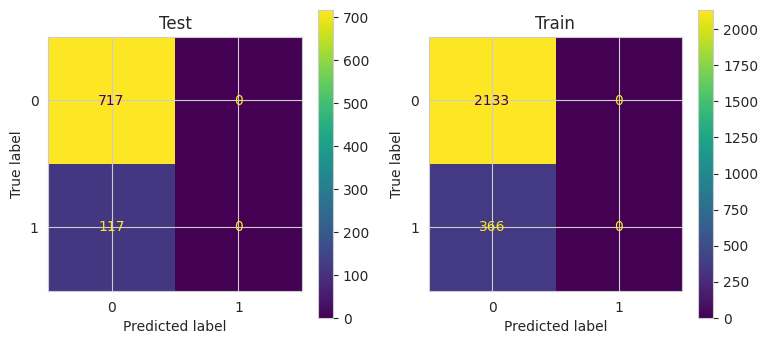

In [46]:
# Plotting confusion matrices
cm_test = confusion_matrix(y_test, y_pred_test)
cm_train = confusion_matrix(y_train, y_pred_train)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot(ax=axes[0])
axes[0].set_title('Test')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp.plot(ax=axes[1])
axes[1].set_title('Train')
plt.show()

> Хоть и предсказания полученной модели показывают довольно высокие значения accuracy, 100% наблюдений модель опеределяет как 0. Это происходит из-за того, что исходно таргетная переменная очень не сбалансирована. Этим объясняется низкий f1-score.

In [48]:
# попробуем теперь бустинг CatBoostClassifier
params = {'n_estimators': range(50, 200, 50),
          'learning_rate': [0.1, 0.01, 0.001], 
          'max_depth': range(5,20,5),
         }
cat_clf = catboost.CatBoostClassifier(verbose=0, random_seed=SEED, thread_count=16)
grid_search_cat_clf = GridSearchCV(cat_clf, params, cv=5)
grid_search_cat_clf.fit(X_train, y_train)

best_model = grid_search_cat_clf.best_estimator_
y_pred = best_model.predict(X_test)

f1_score = f1_score(y_test, y_pred, average='macro', zero_division=0)
accuracy_score = accuracy_score(y_test, y_pred)

print(f'F1 score: {f1_score}')
print(f'Accuracy score: {accuracy_score}')

F1 score: 0.8833479167412102
Accuracy score: 0.9484412470023981


> Используя бустинг, удалось получить не только высокий accuracy, но и высокий f1-score.

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**